<br>

There are several models used in this dataset that are overfitting.
Generally, 100% accuracy is not sensible in Machine Learning. There might be many reasons for this problem. 
It is a fact that using only generated images for training is not good in terms of model accuracy due to the overfitting problem.
I used deep learning models, linear kernal SVM, XGBoost, Radial basis function kernel SVM, LightBoost with best parameters stemmed from hyperparameter tuning, Voting classifier with another classifiers.
<br>
 
 <mark>
I tried 276 principal components and got sufficient results. However, in 2 principal components, results were very good too. This is very compressed data. Maybe this situation is proof of the not-so-good side of the dataset.</mark><br>

<br>
I investigated some papers and posts. I agree with this comment by Zac Yauney below this article (https://machinelearningmastery.com/mostly-generate-synethetic-data-machine-learning-why/).

Part of this comment;
> ... The reason I expect synthetic data to become less useful for training better models is that the goal of a machine learning method is to learn the shape of an underlying statistical distribution, and synthetic data only reflects the algorithm’s current hypothesis about that distribution given the real data it was trained on. ...



## ❗My idea
<p>I tried to <b> increase the entropy of images </b> in datasets by adding random noise. Simply put, entropy is a measurement of uncertainty. I wanted to spoil the data with some uncertainty because it may help our model to generalize and yield a sensible accuracy score without overfitting. </p>

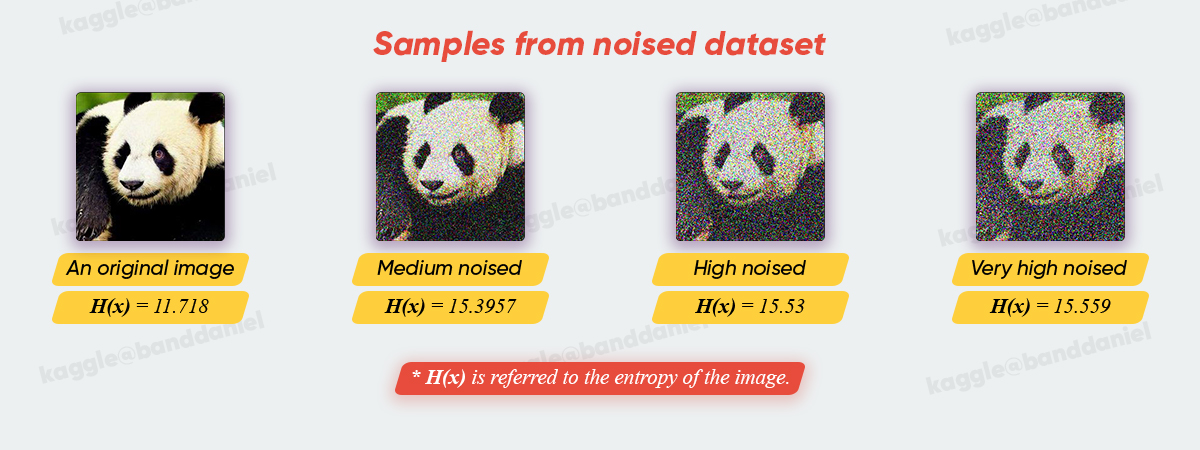
<br>
<span style="font-size:1em; color:gray;"> <i> Figure 1: An original image and its noised samples  </i> </span>

<hr>

## Results 

| <b>Model</b>      | <b>Test Acc <span style='color:#e74c3c'>(2 Comp. PCA)</span></b> | <b>Test Acc <span style='color:#e74c3c'>(276 Comp. PCA)</span></b> | 
| :---------------- | :----------- |:----------- |
| Linear SVM        |   96.75 %   |  95.25 %   | 
| LigthGBM (Tuned)  |   93 %   | 95.5 %| 
| RBF SVM           |     96 %   |  92.5 %  | 
| XGBoost           |     87.25 %   |  95.5 %  | 
| Voting Classifier       |     94.25 %   |  95.5 % | 



In [1]:
# Importing dependencies

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from skimage.util import random_noise
from skimage import io,img_as_float,img_as_ubyte
from skimage.filters import gaussian
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb


In [2]:
# Creating new folders for storing new images 

os.mkdir(os.path.join('/kaggle/working/', 'Train'))
os.mkdir(os.path.join('/kaggle/working/Train', 'Bears'))
os.mkdir(os.path.join('/kaggle/working/Train', 'Pandas'))

os.mkdir(os.path.join('/kaggle/working/', 'Test'))
os.mkdir(os.path.join('/kaggle/working/Test', 'Bears'))
os.mkdir(os.path.join('/kaggle/working/Test', 'Pandas'))

In [3]:
# This function creates 3 new images from an original image with applying gaussian random noise gradually.
# The function saves new images in correspond path.
# New dataset will be 4 times of original dataset in respect of dimensionality.

# example output: original_pandas_100.jpeg med_noise_pandas_100.jpeg, high_noise_pandas_100.jpeg, veryhigh_noise_pandas_100.jpeg


def create_noisy_dataset(main_path, target_path, img_class):
    """
    :param string main_path: main path of dataset (exp. '/kaggle/input/panda-or-bear-image-classification/PandasBears/Train/Bears')
    :param string target_path: target path of new datasets (exp. '/kaggle/working/Train/Bears/')
    :param string img_class: class name (exp. bears or pandas)
    """
    images_dir = os.listdir(main_path)
    
    for i in tqdm(images_dir, desc = 'images'):
      
    
        # original image
        img_original = io.imread(main_path + "/"+i)        
        io.imsave(target_path +"original_"  +img_class +"_" +i , img_as_ubyte(img_original))

        # image array and convertin uint8
        img_arr = np.asarray(img_original, dtype='uint8')
        
        # creating medium noised image
        img_med_noise = random_noise(img_arr , mode='gaussian', var = 0.3**2)
        io.imsave(target_path+"med_noise_" + img_class +"_" +i , img_as_ubyte(img_med_noise))
        
        # creating high noised image
        img_high_noise = random_noise(img_arr , mode='gaussian', var = 0.5**2)
        io.imsave(target_path+"high_noise_" + img_class +"_" +i , img_as_ubyte(img_high_noise))
        
        # creating very high noised image
        img_veryhigh_noise = random_noise(img_arr , mode='gaussian', var = 0.6**2)
        io.imsave(target_path+"veryhigh_noise_" + img_class +"_" +i , img_as_ubyte(img_veryhigh_noise))
        
 
        
        
    print('new datasets created')


In [4]:
# Creating noised datasets

create_noisy_dataset('/kaggle/input/panda-or-bear-image-classification/PandasBears/Train/Pandas', '/kaggle/working/Train/Pandas/', 'pandas' )
create_noisy_dataset('/kaggle/input/panda-or-bear-image-classification/PandasBears/Train/Bears', '/kaggle/working/Train/Bears/', 'bears' )

create_noisy_dataset('/kaggle/input/panda-or-bear-image-classification/PandasBears/Test/Pandas', '/kaggle/working/Test/Pandas/', 'pandas' )
create_noisy_dataset('/kaggle/input/panda-or-bear-image-classification/PandasBears/Test/Bears', '/kaggle/working/Test/Bears/', 'bears' )

images:   0%|          | 0/250 [00:00<?, ?it/s]

new datasets created


images:   0%|          | 0/250 [00:00<?, ?it/s]

new datasets created


images:   0%|          | 0/50 [00:00<?, ?it/s]

new datasets created


images:   0%|          | 0/50 [00:00<?, ?it/s]

new datasets created


In [5]:
# Creating a DataFrame that contain each image path for training.

train_bears_path ='/kaggle/working/Train/Bears'
train_pandas_path ='/kaggle/working/Train/Pandas'

train_bears_images = []
train_pandas_images = []

for i in os.listdir(train_bears_path):
    train_bears_images.append(train_bears_path + "/"+i)
    

for i in os.listdir(train_pandas_path):
    train_pandas_images.append(train_pandas_path + "/"+i)
    
    
train_bears_df = pd.DataFrame({"img": np.array(train_bears_images), "class": "bear"})
train_pandas_df = pd.DataFrame({"img": np.array(train_pandas_images), "class": "panda"})
train_df = pd.concat([train_bears_df,train_pandas_df],ignore_index=True)

print('Train dataset shape -> ' + str( train_df.shape))

Train dataset shape -> (2000, 2)


In [6]:
# Creating a DataFrame that contain each image path for testing.

test_bears_path ='/kaggle/working/Test/Bears'
test_pandas_path ='/kaggle/working/Test/Pandas'

test_bears_images = []
test_pandas_images = []

for i in os.listdir(test_bears_path):
    test_bears_images.append(test_bears_path + "/"+i)
    

for i in os.listdir(test_pandas_path):
    test_pandas_images.append(test_pandas_path + "/"+i)
    
    
test_bears_df = pd.DataFrame({"img": np.array(test_bears_images), "class": "bear"})
test_pandas_df = pd.DataFrame({"img": np.array(test_pandas_images), "class": "panda"})
test_df = pd.concat([test_bears_df,test_pandas_df],ignore_index=True)


print('Test dataset shape -> ' + str( test_df.shape))

Test dataset shape -> (400, 2)


In [7]:
# Reading each image, then resizing to 200*200, and saving of numpy array format

def img_to_npy(path, label):
    """
    :param string path: main path of datasets
    :param string label: label of datasets
    
    """
    images=[]
    labels = []
    for i in os.listdir(path):
        img_path = os.path.join(path, i)
        img = PIL.Image.open(img_path)
        img = img.resize((200,200))
        img = np.array(img)
        images.append(img)
        labels.append(label)
   
    return images, labels

In [8]:
# Creating npy arrays of images
# 0 panda, 1 bear

pandas_train = img_to_npy('/kaggle/working/Train/Pandas', 0)
bears_train = img_to_npy('/kaggle/working/Train/Bears',1)

pandas_test = img_to_npy('/kaggle/working/Test/Pandas', 0)
bears_test = img_to_npy('/kaggle/working/Test/Bears',1)

In [9]:
# Creating final train dataset
# 200*200*3 = 120000 (img_width * img_heigh * channel_number )

train_ =[]
train_labels_ = []

for i in range(len(pandas_train[0])):
    train_.append(pandas_train[0][i].reshape(120000))
    train_labels_.append(pandas_train[1][i])

for i in range(len(bears_train[0])):
    train_.append(bears_train[0][i].reshape(120000))
    train_labels_.append(bears_train[1][i])
    
X_train = np.array(train_)
y_train = np.array(train_labels_)

print(X_train.shape)
print(y_train.shape)

(2000, 120000)
(2000,)


In [10]:
# Creating final test dataset
# 200*200*3 = 120000 (img_width * img_heigh * channel_number )

test_ =[]
test_labels_ = []

for i in range(len(pandas_test[0])):
    test_.append(pandas_test[0][i].reshape(120000))  
    test_labels_.append(pandas_test[1][i])

for i in range(len(bears_test[0])):
    test_.append(bears_test[0][i].reshape(120000))
    test_labels_.append(bears_test[1][i])
    
X_test = np.array(test_)
y_test = np.array(test_labels_)

print(X_test.shape)
print(y_test.shape)

(400, 120000)
(400,)


In [11]:
# Applying StandardScaler()

SC = StandardScaler()
X_train_scaled = SC.fit_transform(X_train)
X_test_scaled = SC.fit_transform(X_test)

Dimensionality reduction from 120000 features reduce to 2 features.

In [12]:
# Applying PCA with 2 components

pca = PCA(n_components = 2)
X_train_2PC = pca.fit_transform(X_train_scaled)
X_test_2PC = pca.fit_transform(X_test_scaled)

# <span style="color:#e74c3c;"> Model 1: </span> Linear SVM


In [13]:
# Linear SVM

linear_svm = SVC( kernel='linear')
linear_svm.fit(X_train_2PC, y_train)
linear_svm_pred = linear_svm.predict(X_test_2PC)
linear_svm_acc = accuracy_score(y_test, linear_svm_pred)*100
print('Test dataset accuracy of Linear SVM :{0:.3f} %'.format(linear_svm_acc))

Test dataset accuracy of Linear SVM :96.750 %


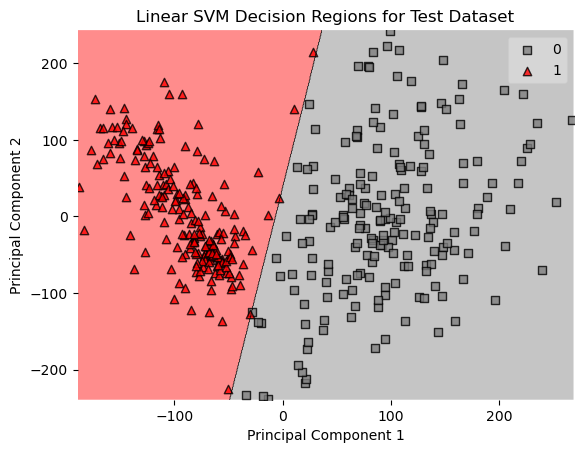

In [14]:
# Linear SVM Plotting Decision Regions

plt.figure(dpi=100)
plot_decision_regions( X_test_2PC, linear_svm_pred , clf=linear_svm, colors ='gray,red' )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('Linear SVM Decision Regions for Test Dataset')
plt.show()


# <span style="color:#e74c3c;"> Model 2: </span> LightGBM

In [15]:
# Tuned LightGBM Classifier 

lgb_model = lgb.LGBMClassifier(learning_rate=0.05, max_bin = 15, max_depth=7, n_estimators=1000, num_leaves=30 )
lgb_model.fit(X_train_2PC, y_train)
lgb_model_pred = lgb_model.predict(X_test_2PC)
lgb_model_acc = accuracy_score(y_test, lgb_model_pred)*100
print('Test dataset accuracy of LGBM : {0:.2f} %'.format(lgb_model_acc))


Test dataset accuracy of LGBM : 93.50 %


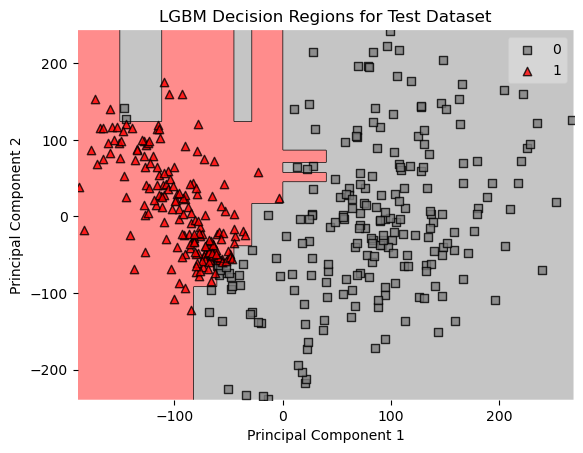

In [16]:
# LGBM Plotting Decision Regions

plt.figure(dpi=100)
plot_decision_regions( X_test_2PC, lgb_model_pred , clf=lgb_model, colors ='gray,red' )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('LGBM Decision Regions for Test Dataset')
plt.show()

# <span style="color:#e74c3c;"> Model 3: </span> Radial basis function kernel SVM

In [17]:
# RBF SVM

kernel_svm = SVC( kernel='rbf'  )
kernel_svm.fit(X_train_2PC, y_train)
kernel_svm_pred = kernel_svm.predict(X_test_2PC)
kernel_svm_acc = accuracy_score(y_test,kernel_svm_pred )*100
print('Test dataset accuracy of RBF SVM : {0:.3f} %'.format(kernel_svm_acc))

Test dataset accuracy of RBF SVM : 96.000 %


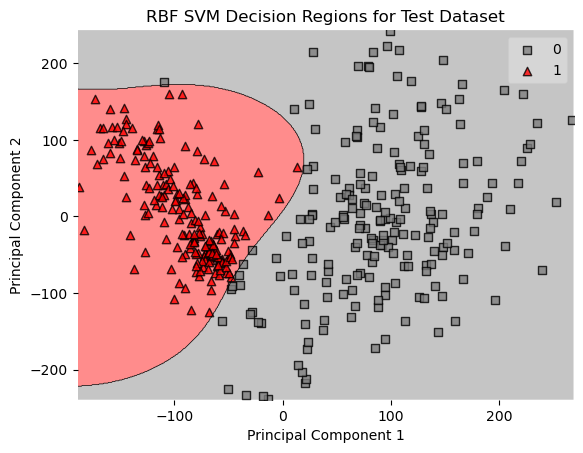

In [18]:
# RBF SVM Plotting Decision Regions

plt.figure(dpi=100)
plot_decision_regions( X_test_2PC, kernel_svm_pred , clf=kernel_svm, colors ='gray,red' )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('RBF SVM Decision Regions for Test Dataset')
plt.show()


# <span style="color:#e74c3c;"> Model 4: </span> XGB

In [19]:
# XGB

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_2PC, y_train)
xgb_pred = xgb_model.predict(X_test_2PC)
acc_xgb = accuracy_score(y_test, xgb_pred )*100
print('Test dataset accuracy of XGB : {0:.3f} %'.format(acc_xgb))

Test dataset accuracy of XGB : 88.250 %


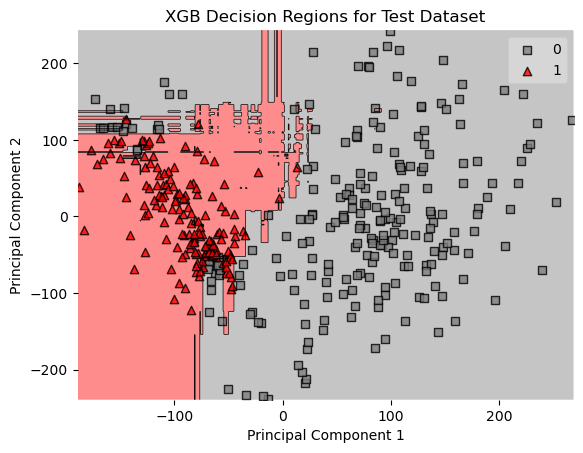

In [20]:
# RBF SVM Plotting Decision Regions

plt.figure(dpi=100)
plot_decision_regions( X_test_2PC, xgb_pred , clf=xgb_model, colors ='gray,red' )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('XGB Decision Regions for Test Dataset')
plt.show()


# <span style="color:#e74c3c;"> Model 5: </span> Ensemble Method (Voting Classifier)

In [21]:
vot = VotingClassifier(estimators=[('linear_svm', linear_svm ), ('lgb_model', lgb_model),('kernel_svm', kernel_svm), 
                                   ('xgb_model', xgb_model) ])

vot.fit(X_train_2PC, y_train)

vot_pred = vot.predict(X_test_2PC)
vot_acc = accuracy_score(y_test, vot_pred )*100
print('Test dataset accuracy of Voting : {0:.3f} %'.format(vot_acc))

Test dataset accuracy of Voting : 94.750 %


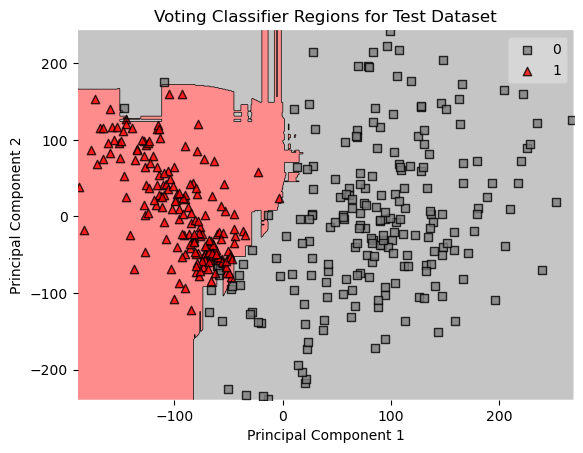

In [22]:
plt.figure(dpi=100)
plot_decision_regions( X_test_2PC, vot_pred, clf=vot, colors ='gray,red' )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('Voting Classifier Regions for Test Dataset')
plt.show()

# <span style="color:#e74c3c;"> Results </span> Confusion Matrices

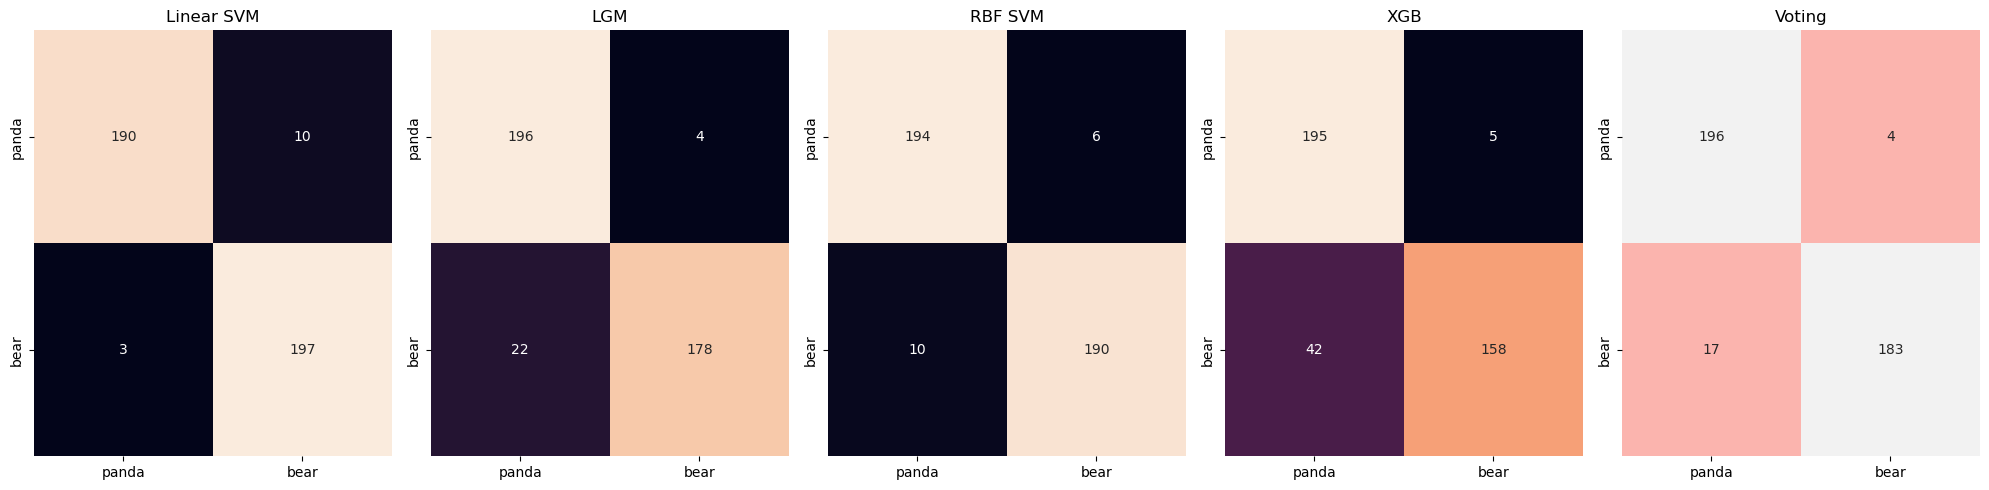

In [23]:
lineal_svm_cfm = confusion_matrix(y_test, linear_svm_pred)
lgb_cfm = confusion_matrix(y_test, lgb_model_pred)
kernel_svm_cfm = confusion_matrix(y_test, kernel_svm_pred)
xgb_cfm = confusion_matrix(y_test, xgb_pred)
vot_cfm = confusion_matrix(y_test, vot_pred)

fig, axs = plt.subplots(1,5, figsize = (20,5), sharex='col')
sns.heatmap(lineal_svm_cfm,ax= axs[0], annot=True, fmt = '.0f', cbar= False, xticklabels = ['panda', 'bear'], yticklabels = ['panda', 'bear'] )
axs[0].set_title('Linear SVM')

sns.heatmap(lgb_cfm,ax = axs[1],  annot=True, fmt = '.0f', cbar= False,xticklabels = ['panda', 'bear'], yticklabels = ['panda', 'bear'] )
axs[1].set_title('LGM')

sns.heatmap( kernel_svm_cfm,ax = axs[2], annot=True, fmt = '.0f', cbar= False,xticklabels = ['panda', 'bear'], yticklabels = ['panda', 'bear'] )
axs[2].set_title('RBF SVM')

sns.heatmap(xgb_cfm,ax = axs[3],  annot=True, fmt = '.0f', cbar= False,xticklabels = ['panda', 'bear'], yticklabels = ['panda', 'bear'] )
axs[3].set_title('XGB')

sns.heatmap(vot_cfm,ax = axs[4],  annot=True, fmt = '.0f', cbar= False,xticklabels = ['panda', 'bear'], yticklabels = ['panda', 'bear'], cmap='Pastel1' )
axs[4].set_title('Voting')

plt.tight_layout()
plt.show()


# <span style="color:#e74c3c;"> Models with </span> 276 Components PCA (95 % Variance Ratio)

Dimensionality reduction from 120000 features reduce to 276 features. In brief, these components contain nearly 95% knowledge of all features, which is sufficient for training a model.

In [24]:
# Applying PCA with 276 components

pca = PCA(n_components = 276)
X_train_276PC = pca.fit_transform(X_train_scaled)
X_test_276PC = pca.fit_transform(X_test_scaled)

print(X_train_276PC.shape)

(2000, 276)


In [25]:
# 1 Linear SVM

linear_svm = SVC( kernel='linear')
linear_svm.fit(X_train_276PC, y_train)
linear_svm_pred = linear_svm.predict(X_test_276PC)
linear_svm_acc = accuracy_score(y_test, linear_svm_pred)*100
print('Test dataset accuracy of Linear SVM :{0:.3f} %'.format(linear_svm_acc))

Test dataset accuracy of Linear SVM :93.750 %


In [26]:
# 2 Tuned LightGBM Classifier 

lgb_model = lgb.LGBMClassifier(learning_rate=0.05, max_bin = 15, max_depth=7, n_estimators=1000, num_leaves=30 )
lgb_model.fit(X_train_276PC, y_train)
lgb_model_pred = lgb_model.predict(X_test_276PC)
lgb_model_acc = accuracy_score(y_test, lgb_model_pred)*100
print('Test dataset accuracy of LGBM : {0:.2f} %'.format(lgb_model_acc))

Test dataset accuracy of LGBM : 95.75 %


In [27]:
# 3 RBF SVM

kernel_svm = SVC( kernel='rbf'  )
kernel_svm.fit(X_train_276PC, y_train)
kernel_svm_pred = kernel_svm.predict(X_test_276PC)
kernel_svm_acc = accuracy_score(y_test,kernel_svm_pred )*100
print('Test dataset accuracy of RBF SVM : {0:.3f} %'.format(kernel_svm_acc))

Test dataset accuracy of RBF SVM : 94.000 %


In [28]:
# 4 XGB

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_276PC, y_train)
xgb_pred = xgb_model.predict(X_test_276PC)
acc_xgb = accuracy_score(y_test, xgb_pred )*100
print('Test dataset accuracy of XGB : {0:.3f} %'.format(acc_xgb))

Test dataset accuracy of XGB : 95.750 %


In [29]:
# 5 Voting Classifier

vot = VotingClassifier(estimators=[('linear_svm', linear_svm ), ('lgb_model', lgb_model),('kernel_svm', kernel_svm), 
                                   ('xgb_model', xgb_model) ])

vot.fit(X_train_276PC, y_train)

vot_pred = vot.predict(X_test_276PC)
vot_acc = accuracy_score(y_test, vot_pred )*100
print('Test dataset accuracy of Voting : {0:.3f} %'.format(vot_acc))

Test dataset accuracy of Voting : 95.500 %
